# MLFlow

Pour rappel, la documentation Python de MLFlow se trouve à l'adresse :


https://mlflow.org/docs/latest/python_api/index.html

Vous allez suivre plusieurs étapes (plusieurs fonctions) qui permettront de lancer des exécutions successives dans la dernière cellule.

## Modélisation 
### Importation des librairies

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature

import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Importation des données : Cancer

Récupérez le fichier cancer450.csv et générez en son dataframe.
Affiche- le pour vérifier la bonne importation des données.

In [3]:
#**A COMPLETER**
file_path = '../../Data/cancer450.csv'
df = pd.read_csv(file_path)
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,tumor
0,19.160,26.60,126.20,1138.0,0.10200,0.14530,0.19210,0.096640,0.1902,0.06220,...,35.90,159.80,1724.0,0.1782,0.3841,0.57540,0.18720,0.3258,0.09720,malignant
1,11.570,19.04,74.20,409.7,0.08546,0.07722,0.05485,0.014280,0.2031,0.06267,...,26.98,86.43,520.5,0.1249,0.1937,0.25600,0.06664,0.3035,0.08284,benign
2,11.040,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.024800,0.1714,0.06340,...,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881,benign
3,12.220,20.04,79.47,453.1,0.10960,0.11520,0.08175,0.021660,0.2124,0.06894,...,24.17,85.13,515.3,0.1402,0.2315,0.35350,0.08088,0.2709,0.08839,benign
4,13.800,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.050690,0.1662,0.06566,...,20.86,110.30,812.4,0.1411,0.3542,0.27790,0.13830,0.2589,0.10300,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,11.430,17.31,73.66,398.0,0.10920,0.09486,0.02031,0.018610,0.1645,0.06562,...,26.76,82.66,503.0,0.1413,0.1792,0.07708,0.06402,0.2584,0.08096,benign
446,10.570,20.22,70.15,338.3,0.09073,0.16600,0.22800,0.059410,0.2188,0.08450,...,22.82,76.51,351.9,0.1143,0.3619,0.60300,0.14650,0.2597,0.12000,benign
447,9.397,21.68,59.75,268.8,0.07969,0.06053,0.03735,0.005128,0.1274,0.06724,...,27.99,66.61,301.0,0.1086,0.1887,0.18680,0.02564,0.2376,0.09206,benign
448,8.726,15.83,55.84,230.9,0.11500,0.08201,0.04132,0.019240,0.1649,0.07633,...,19.62,64.48,284.4,0.1724,0.2364,0.24560,0.10500,0.2926,0.10170,benign


### Split du jeu d'entrainement et de test

Séparez le jeu de données en entraînement et test à 80% et une graine de 42.
Pour rappel, la variable cible est "tumor".

In [4]:
#**A COMPLETER**
X = df.drop('tumor', axis=1) 
y = df['tumor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Liste des modèles

Nous allons travailler avec les modèles suivants : 
* DecisionTree
* LogisticRegression
* SVC
* GaussianNB
* KNeigbors

In [5]:
liste = ['DT','LR','SVM','NB','KNN']

### Hyperparamètres

Pour chaque modèle, nous définissons les hyperparamètres dont certains avec de façon aléatoire afin de simuler différentes exécutions.

In [6]:
def hyperparametre(modele):
    if modele == 'DT':
        params = {
            "criterion": 'gini',  # La fonction pour mesurer la qualité d'une scission. Supporté : "gini" pour l'impureté de Gini, "entropy" pour le gain d'information.
            "splitter": 'best',  # La stratégie utilisée pour choisir la scission à chaque nœud. Supporté : "best" pour choisir la meilleure scission, "random" pour choisir la meilleure scission aléatoire.
            "max_depth": None,  # La profondeur maximale de l'arbre. Si None, alors les nœuds sont étendus jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins que min_samples_split échantillons.
            "min_samples_split": random.randint(2, 50),  # Le nombre minimum d'échantillons requis pour scinder un nœud interne.
            "min_samples_leaf": random.randint(1, 2),  # Le nombre minimum d'échantillons requis pour être à un nœud feuille.
            "min_weight_fraction_leaf": 0.,  # La fraction pondérée minimale de la somme totale des poids (de tous les échantillons d'entrée) requise pour être à un nœud feuille.
            "max_features": None,  # Le nombre de fonctionnalités à considérer lors de la recherche de la meilleure scission. Si None, alors max_features=n_features.
            "random_state": None,  # Contrôle la randomicité de l'estimateur. Les valeurs de l'état aléatoire différentes peuvent changer le comportement de l'arbre.
            "max_leaf_nodes": None,  # Développe un arbre avec max_leaf_nodes de la meilleure façon. Si None, alors un nombre illimité de nœuds feuilles.
            "min_impurity_decrease": 0.,  # Un nœud sera scindé si cette scission induit une diminution de l'impureté supérieure ou égale à cette valeur.
            "class_weight": None,  # Poids associés aux classes. Si None, toutes les classes sont censées avoir un poids un.
            "ccp_alpha": 0.0,  # Paramètre de complexité utilisé pour la taille minimale de l'arbre de coût-complexité. Plus grande est la valeur de alpha, plus le nombre de nœuds est réduit.
        }
    elif modele == 'LR':
        params = {
            "penalty": 'l2',  # Spécifie la norme utilisée dans la pénalisation. Les valeurs les plus courantes sont 'l2' et 'l1'.
            "dual": False,  # Formulation duale ou primale. La formulation duale est seulement implémentée pour la pénalité 'l2' avec des solveurs 'liblinear'. Préférer False dans la majorité des cas.
            "tol": 1e-4,  # Tolérance pour les critères d'arrêt.
            "C": 1.0,  # Inverse de la force de régularisation; doit être un flottant positif. Comme dans les machines à vecteurs de support, des valeurs plus petites spécifient une régularisation plus forte.
            "fit_intercept": True,  # Spécifie si une constante (a.k.a. biais ou intercept) doit être ajoutée à la fonction de décision.
            "intercept_scaling": random.randint(1, 5),  # Utile seulement lorsque le solveur 'liblinear' est utilisé et 'fit_intercept' est défini à True. Dans ce cas, x devient [x, self.intercept_scaling], c'est-à-dire une colonne "synthétique" de poids égaux à intercept_scaling est ajoutée à l'instance vectorielle x.
            "class_weight": None,  # Poids associés aux classes. Si non spécifié, toutes les classes ont un poids un.
            "random_state": None,  # Le seed du générateur de nombres pseudo-aléatoires à utiliser lors de la mélange des données.
            "solver": 'lbfgs',  # Algorithme à utiliser dans le problème d'optimisation. Pour les petits ensembles de données, 'liblinear' est un bon choix, tandis que 'sag' et 'saga' sont plus rapides pour les grands.
            "max_iter": random.randint(1, 1000),  # Nombre maximal d'itérations prises pour que les solveurs convergent.
            "multi_class": 'auto',  # Si le choix 'auto', le choix du binaire ou de l'un contre le reste dépend du type de données et du solveur.
            "verbose": random.randint(1, 10),  # Pour le solveur 'liblinear' et 'lbfgs', définir verbose à tout nombre positif pour la verbosité.
            "warm_start": False,  # Lorsqu'il est défini à True, réutilise la solution de l'appel précédent pour s'adapter comme initialisation, sinon, efface simplement la solution précédente.
            "n_jobs": None,  # Nombre de cœurs CPU à utiliser lors de la parallélisation sur des classes. 'None' signifie 1 sauf dans un contexte joblib.parallel_backend. '-1' signifie utiliser tous les processeurs.
            "l1_ratio": None,  # Le ratio de mélange L1, uniquement utilisé si penalty='elasticnet'. 'l1_ratio=0' correspond à une pénalité L2, 'l1_ratio=1' à une L1. Pour '0 < l1_ratio < 1', la pénalité est une combinaison de L1 et L2.
        }
    elif modele == 'SVM':
        params = {
            "C": 1.0,  # Paramètre de régularisation. La force de la régularisation est inversement proportionnelle à C. Doit être strictement positif. La pénalité est une norme au carré l2.
            "kernel": 'rbf',  # Spécifie le type de noyau à utiliser dans l'algorithme. Il doit être 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' ou un appelable.
            "degree": random.randint(1, 5),  # Degré de la fonction du noyau polynomial ('poly'). Ignoré par tous les autres noyaux.
            "gamma": 'scale',  # Coefficient du noyau pour 'rbf', 'poly' et 'sigmoid'. Si 'gamma'='scale' (par défaut) est passé alors il utilise 1 / (n_features * X.var()) comme valeur de gamma, si 'auto', utilise 1 / n_features.
            "coef0": 0.0,  # Terme indépendant dans la fonction du noyau. C'est seulement significatif dans 'poly' et 'sigmoid'.
            "shrinking": True,  # Utilise la heuristique de shrinking ou non.
            "probability": False,  # Si vrai, active les estimations de probabilité, ce qui ralentit cette méthode.
            "tol": 1e-3,  # Tolérance pour le critère d'arrêt.
            "cache_size": random.randint(1, 1000),  # Taille du cache du noyau (en Mo).
            "class_weight": None,  # Poids associés aux classes dans le format {classe_label: poids}. Si non spécifié, toutes les classes ont un poids un.
            "verbose": False,  # Active la sortie verbosité.
            "max_iter": -1,  # Limite stricte sur les itérations au sein du solveur, ou -1 pour aucune limite.
            "decision_function_shape": 'ovr',  # Si 'ovr', renvoie la fonction de décision one-vs-rest (n_classes, n_samples) comme toutes les autres classificateurs. Si 'ovo', la fonction de décision one-vs-one (libsvm) est renvoyée (n_classes * (n_classes - 1) / 2, n_samples). Cependant, on peut toujours utiliser `one-vs-rest` en passant 'ovr' à l'option `decision_function_shape` du classificateur `OneVsRestClassifier` explicitement.
            "break_ties": False,  # Si vrai, la décision de 'decision_function_shape'='ovr', et le nombre de classes > 2, la prédiction brisera les liens selon les valeurs de la fonction de décision. Sinon, le premier parmi les classes liées sera renvoyé.
            "random_state": None,  # Le seed du générateur de nombres pseudo-aléatoires utilisé lors du mélange des données pour les probabilités d'estimation. Ignoré lorsque 'probability' est False.
        }
    elif modele == 'NB':
        params = {
            "var_smoothing": 1e-9,  # Portion de la variance la plus grande de toutes les caractéristiques qui est ajoutée à la variance pour la stabilité du calcul.
        }
    elif modele == 'KNN':
        params = {
            "n_neighbors": random.randint(1, 10),  # nombre de voisins à utiliser
            "weights": 'uniform',  # poids des points, peut être 'uniform' ou 'distance' ou une fonction personnalisée
            "algorithm": 'auto',  # algorithme utilisé pour calculer les voisins les plus proches, peut être 'auto', 'ball_tree', 'kd_tree', 'brute'
            "leaf_size": random.randint(1, 30),  # taille de la feuille passée à BallTree ou KDTree
            "p": 2,  # paramètre de puissance pour la métrique Minkowski
            "metric": 'minkowski',  # la métrique de distance à utiliser pour l'arbre
            "metric_params": None,  # arguments supplémentaires pour la métrique de distance
            "n_jobs": None,  # nombre de travaux parallèles à exécuter pour la recherche de voisins
        }
    
    return params

### Entraînement et prédiction du modèle

La fonction suivante **entrainement_prediction(n)** est défini comme suit :
- ENTREE : name_model qui représente le nom du modèle
- SORTIE : retourne le modèle et les prédictions

Affecter chaque modèle avec la fonction sklearn qui lui est propre en prenant en compte les hyperparamètres (fonction précédente : hyperparametre(modele)).

In [7]:
def entrainement_prediction(name_model):
    if name_model == 'DT':
        modele = DecisionTreeClassifier(**hyperparametre(name_model)) #**A COMPLETER**
    elif name_model == 'LR':
        modele = LogisticRegression(**hyperparametre(name_model)) #**A COMPLETER**
    elif name_model == 'SVM':
        modele = SVC(**hyperparametre(name_model)) #**A COMPLETER**
    elif name_model == 'NB':
        modele = GaussianNB(**hyperparametre(name_model)) #**A COMPLETER**
    elif name_model == 'KNN':
        modele = KNeighborsClassifier(**hyperparametre(name_model)) #**A COMPLETER**
    modele.fit(X_train, y_train)
    return modele, modele.predict(X_test)

### Calculs des metriques

Calculez-les métriques suivantes sous forme de fonction :
* **accuracy(y_test, y_pred)**
* **precision(y_test, y_pred)**
* **recall(y_test, y_pred)**
* **f1(y_test, y_pred)**

In [8]:
def accuracy(y_test, y_pred):
    return accuracy_score(y_test, y_pred) #**A COMPLETER**

def precision(y_test, y_pred):
    return precision_score(y_test, y_pred, average='macro') #**A COMPLETER**

def recall(y_test, y_pred):
    return recall_score(y_test, y_pred, average='macro') #**A COMPLETER**

def f1(y_test, y_pred):
    return f1_score(y_test, y_pred, average='macro') #**A COMPLETER**

### Matrice de confusion

Cette fonction **conf_matrix(y_test, y_pred)** créé la matrice de confusion, la génère avec matplotlib.pyplot, l'enregistre dans le fichier confusion_matrix.png et retourne le chemin de l'image enregistré sur le disque.

In [9]:
#**A COMPLETER**
def conf_matrix(y_test, y_pred):
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Génération de la matrice de confusion avec matplotlib
    fig, ax = plt.subplots()
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(np.unique(df['tumor']))
    ax.yaxis.set_ticklabels(np.unique(df['tumor']))
    # Sauvegarde de la figure
    fig_path = "confusion_matrix.png"
    fig.savefig(fig_path)
    return fig_path

## Trace des expériences

Le serveur de suivi (tracking server) est utilisé pour enregistrer et consulter les métriques, les paramètres et les artefacts associés aux différentes exécutions de votre programme de machine learning (expériences). 

Dans votre environnement et dans une console, démarrez le serveur MLFlow (cherchez dans la documentation) et vérifiez que le serveur est actif en saisissant l'adresse `http://127.0.0.1:5000` dans un navigateur.

#mlflow server --host 127.0.0.1 --port 5000

### Définition de l'URI du serveur

Spécifiez l'URI du tracking server en local sur le port 5000.

Vous trouverez l'information dans la documentation Python de MLFlow :
https://www.mlflow.org/docs/latest/getting-started/intro-quickstart/index.html

In [10]:
#**A COMPLETER**
mlflow.set_tracking_uri("http://127.0.0.1:5000") 
print(f"Tracking Server URI: '{mlflow.get_tracking_uri()}'")

Tracking Server URI: 'http://127.0.0.1:5000'


### Création d'une nouvelle experience

L'expérience va vous servir à organiser toutes vos exécutions. 

Appelez-la "Experience_cancer" (set_experiment).

In [11]:
#**A COMPLETER**
mlflow.set_experiment("Experience_cancer")

<Experiment: artifact_location='mlflow-artifacts:/605743655153235326', creation_time=1709473635692, experiment_id='605743655153235326', last_update_time=1709473635692, lifecycle_stage='active', name='Experience_cancer', tags={}>

### Suivi des exécutions

Lancez la cellule suivante et observez le résultat sur l'interface MLFlow.

Il vous faut compléter au fur et à mesure la cellule tout en relançant l'exécution entre chaque étape ci-dessous pour observer le résultat :

1. Récupérez les **prédictions** à partir de la fonction `entrainement_prediction()` et affectez-les à une variable `y_pred`
2. Récupérez les **métriques de log** (voir `log_system_metrics` et `time.sleep`)
   https://mlflow.org/docs/latest/system-metrics/index.html
3. Chargez les **hyperparamètres** avec la fonction `hyperparametre()` (voir `log_param`)
4. Ajoutez des **tags** d'information sur le modèle utilisé, par exemple (voir `set_tag`)
5. Chargez les **métriques** dans MLFlow (voir `log_metric`)
6. Chargez la **matrice de confusion** comme artefact avec la fonction précédente `conf_matrix()` (voir `log_artifact`)
7. Chargez les **données** comme artefact (voir `log_artifact`)
8. Ajoutez le **dataset** de test dans l'interface des expériences (à l'identique que celui d'entrainement)
9. Chargez le **modèle** dans la variable `sk_model` à l'aide de la fonction `entrainement_prediction()`

DT


2024/03/04 23:36:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:36:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/04 23:37:21 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:37:21 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9333333333333333,
 'f1': 0.9290966386554622,
 'precision': 0.9346092503987241,
 'recall': 0.9246753246753247,
 'system/cpu_utilization_percentage': 17.7,
 'system/disk_available_megabytes': 111588.5,
 'system/disk_usage_megabytes': 397181.6,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.12365400000001614,
 'system/network_transmit_megabytes': 0.1764220000000023,
 'system/system_memory_usage_megabytes': 15238.9,
 'system/system_memory_usage_percentage': 89.6}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'ccp_alpha': '0.0',
 'class_weight': 'None',
 'criterion': 'gini',
 'max_depth': 'None',
 'max_features': 'None',
 'max_leaf_nodes': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '1',
 'min_samples_split': '31',
 'min_weight_fraction_leaf': '0.0',
 'random_state': 'None',
 'splitter': 'best'}, tags={'Dataset information': 'Cancer',
 'Model used': 'DT',
 'mlflow.log-model.history'

2024/03/04 23:37:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:37:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/04 23:37:41 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:37:41 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:37:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:37:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9444444444444444,
 'f1': 0.9418529525778525,
 'precision': 0.9398148148148148,
 'recall': 0.9441558441558442,
 'system/cpu_utilization_percentage': 19.1,
 'system/disk_available_megabytes': 111590.1,
 'system/disk_usage_megabytes': 397180.0,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15181.1,
 'system/system_memory_usage_percentage': 89.3}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '1',
 'l1_ratio': 'None',
 'max_iter': '152',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': 'None',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '10',
 'warm_start': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'LR',
 'mlflow.log-model.history': '[{"run_id": "0850a19242

2024/03/04 23:38:00 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:38:00 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:38:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:38:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.8888888888888888,
 'f1': 0.8769819573537452,
 'precision': 0.91005291005291,
 'recall': 0.8623376623376624,
 'system/cpu_utilization_percentage': 21.2,
 'system/disk_available_megabytes': 111585.5,
 'system/disk_usage_megabytes': 397184.6,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15095.5,
 'system/system_memory_usage_percentage': 88.8}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'break_ties': 'False',
 'cache_size': '186',
 'class_weight': 'None',
 'coef0': '0.0',
 'decision_function_shape': 'ovr',
 'degree': '5',
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': '-1',
 'probability': 'False',
 'random_state': 'None',
 'shrinking': 'True',
 'tol': '0.001',
 'verbose': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'SVM',
 'mlflow.log-model.history': '[{"run_id": "da9d69923

2024/03/04 23:38:19 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:38:19 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9555555555555556,
 'f1': 0.9527310924369747,
 'precision': 0.9585326953748006,
 'recall': 0.948051948051948,
 'system/cpu_utilization_percentage': 23.1,
 'system/disk_available_megabytes': 111584.1,
 'system/disk_usage_megabytes': 397186.0,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15134.5,
 'system/system_memory_usage_percentage': 89.0}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'var_smoothing': '1e-09'}, tags={'Dataset information': 'Cancer',
 'Model used': 'NB',
 'mlflow.log-model.history': '[{"run_id": "5c53aed1d5ae4ce6aca1e35c321ec063", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
                             '22:38:16.106454", "flavors": {"python_function": '
                             '{"model_path": "model.p

2024/03/04 23:38:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:38:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/04 23:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:38:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9,
 'f1': 0.8901098901098901,
 'precision': 0.9176267281105991,
 'recall': 0.8766233766233766,
 'system/cpu_utilization_percentage': 21.9,
 'system/disk_available_megabytes': 111583.6,
 'system/disk_usage_megabytes': 397186.6,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15257.2,
 'system/system_memory_usage_percentage': 89.7}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'algorithm': 'auto',
 'leaf_size': '18',
 'metric': 'minkowski',
 'metric_params': 'None',
 'n_jobs': 'None',
 'n_neighbors': '10',
 'p': '2',
 'weights': 'uniform'}, tags={'Dataset information': 'Cancer',
 'Model used': 'KNN',
 'mlflow.log-model.history': '[{"run_id": "f4374044d57f4ff092c1ba97901951c0", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
       

2024/03/04 23:38:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:38:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9111111111111111,
 'f1': 0.9064935064935065,
 'precision': 0.9064935064935065,
 'recall': 0.9064935064935065,
 'system/cpu_utilization_percentage': 20.8,
 'system/disk_available_megabytes': 111583.4,
 'system/disk_usage_megabytes': 397186.7,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15031.3,
 'system/system_memory_usage_percentage': 88.4}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'ccp_alpha': '0.0',
 'class_weight': 'None',
 'criterion': 'gini',
 'max_depth': 'None',
 'max_features': 'None',
 'max_leaf_nodes': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '1',
 'min_samples_split': '37',
 'min_weight_fraction_leaf': '0.0',
 'random_state': 'None',
 'splitter': 'best'}, tags={'Dataset information': 'Cancer',
 'Model used': 'DT',
 'mlflow.log-model.history': '[{"run_id": "5277db6725ba442

2024/03/04 23:38:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:38:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/04 23:39:18 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:39:18 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:39:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:39:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9444444444444444,
 'f1': 0.9418529525778525,
 'precision': 0.9398148148148148,
 'recall': 0.9441558441558442,
 'system/cpu_utilization_percentage': 20.2,
 'system/disk_available_megabytes': 111580.5,
 'system/disk_usage_megabytes': 397189.7,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14991.2,
 'system/system_memory_usage_percentage': 88.2}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '4',
 'l1_ratio': 'None',
 'max_iter': '953',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': 'None',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '3',
 'warm_start': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'LR',
 'mlflow.log-model.history': '[{"run_id": "4b1174b7ad5

2024/03/04 23:39:37 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:39:37 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:39:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:39:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.8888888888888888,
 'f1': 0.8769819573537452,
 'precision': 0.91005291005291,
 'recall': 0.8623376623376624,
 'system/cpu_utilization_percentage': 23.3,
 'system/disk_available_megabytes': 111578.3,
 'system/disk_usage_megabytes': 397191.8,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14994.8,
 'system/system_memory_usage_percentage': 88.2}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'break_ties': 'False',
 'cache_size': '998',
 'class_weight': 'None',
 'coef0': '0.0',
 'decision_function_shape': 'ovr',
 'degree': '2',
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': '-1',
 'probability': 'False',
 'random_state': 'None',
 'shrinking': 'True',
 'tol': '0.001',
 'verbose': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'SVM',
 'mlflow.log-model.history': '[{"run_id": "2127427c7

2024/03/04 23:39:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:39:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:39:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:39:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9555555555555556,
 'f1': 0.9527310924369747,
 'precision': 0.9585326953748006,
 'recall': 0.948051948051948,
 'system/cpu_utilization_percentage': 19.7,
 'system/disk_available_megabytes': 111576.5,
 'system/disk_usage_megabytes': 397193.6,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14690.4,
 'system/system_memory_usage_percentage': 86.4}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'var_smoothing': '1e-09'}, tags={'Dataset information': 'Cancer',
 'Model used': 'NB',
 'mlflow.log-model.history': '[{"run_id": "9ab2933bfc2545a99b3d3f8b350285fb", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
                             '22:39:53.139975", "flavors": {"python_function": '
                             '{"model_path": "model.p

2024/03/04 23:40:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:40:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:40:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:40:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9,
 'f1': 0.8953353146401344,
 'precision': 0.8935185185185186,
 'recall': 0.8974025974025974,
 'system/cpu_utilization_percentage': 21.6,
 'system/disk_available_megabytes': 111574.9,
 'system/disk_usage_megabytes': 397195.2,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14721.8,
 'system/system_memory_usage_percentage': 86.6}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'algorithm': 'auto',
 'leaf_size': '12',
 'metric': 'minkowski',
 'metric_params': 'None',
 'n_jobs': 'None',
 'n_neighbors': '4',
 'p': '2',
 'weights': 'uniform'}, tags={'Dataset information': 'Cancer',
 'Model used': 'KNN',
 'mlflow.log-model.history': '[{"run_id": "4cb146f532e54a6a9c7ca84618fc7d57", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
        

2024/03/04 23:40:34 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:40:34 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9333333333333333,
 'f1': 0.9290966386554622,
 'precision': 0.9346092503987241,
 'recall': 0.9246753246753247,
 'system/cpu_utilization_percentage': 19.2,
 'system/disk_available_megabytes': 111574.7,
 'system/disk_usage_megabytes': 397195.4,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14776.0,
 'system/system_memory_usage_percentage': 86.9}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'ccp_alpha': '0.0',
 'class_weight': 'None',
 'criterion': 'gini',
 'max_depth': 'None',
 'max_features': 'None',
 'max_leaf_nodes': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '1',
 'min_samples_split': '13',
 'min_weight_fraction_leaf': '0.0',
 'random_state': 'None',
 'splitter': 'best'}, tags={'Dataset information': 'Cancer',
 'Model used': 'DT',
 'mlflow.log-model.history': '[{"run_id": "2bc7e446c8bf44d

2024/03/04 23:40:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:40:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/03/04 23:40:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:40:54 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:40:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:40:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9444444444444444,
 'f1': 0.9418529525778525,
 'precision': 0.9398148148148148,
 'recall': 0.9441558441558442,
 'system/cpu_utilization_percentage': 20.6,
 'system/disk_available_megabytes': 111577.7,
 'system/disk_usage_megabytes': 397192.4,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 15149.9,
 'system/system_memory_usage_percentage': 89.1}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '2',
 'l1_ratio': 'None',
 'max_iter': '688',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': 'None',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '5',
 'warm_start': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'LR',
 'mlflow.log-model.history': '[{"run_id": "6bc01df5148

2024/03/04 23:41:13 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:41:13 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:41:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:41:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.8888888888888888,
 'f1': 0.8769819573537452,
 'precision': 0.91005291005291,
 'recall': 0.8623376623376624,
 'system/cpu_utilization_percentage': 19.6,
 'system/disk_available_megabytes': 111575.9,
 'system/disk_usage_megabytes': 397194.2,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0011140000000011696,
 'system/network_transmit_megabytes': 0.007144000000153028,
 'system/system_memory_usage_megabytes': 15098.6,
 'system/system_memory_usage_percentage': 88.8}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'break_ties': 'False',
 'cache_size': '767',
 'class_weight': 'None',
 'coef0': '0.0',
 'decision_function_shape': 'ovr',
 'degree': '1',
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': '-1',
 'probability': 'False',
 'random_state': 'None',
 'shrinking': 'True',
 'tol': '0.001',
 'verbose': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'SVM',
 'mlflow.log-mode

2024/03/04 23:41:32 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:41:32 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:41:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:41:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9555555555555556,
 'f1': 0.9527310924369747,
 'precision': 0.9585326953748006,
 'recall': 0.948051948051948,
 'system/cpu_utilization_percentage': 24.1,
 'system/disk_available_megabytes': 111581.9,
 'system/disk_usage_megabytes': 397188.2,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14882.5,
 'system/system_memory_usage_percentage': 87.5}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'var_smoothing': '1e-09'}, tags={'Dataset information': 'Cancer',
 'Model used': 'NB',
 'mlflow.log-model.history': '[{"run_id": "7bc700e4f8804578aa5232b633d70ae5", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
                             '22:41:29.208111", "flavors": {"python_function": '
                             '{"model_path": "model.p

2024/03/04 23:41:51 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:41:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:41:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:41:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9,
 'f1': 0.8942420681551116,
 'precision': 0.8965336134453781,
 'recall': 0.8922077922077922,
 'system/cpu_utilization_percentage': 22.4,
 'system/disk_available_megabytes': 111577.3,
 'system/disk_usage_megabytes': 397192.8,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14831.3,
 'system/system_memory_usage_percentage': 87.2}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'algorithm': 'auto',
 'leaf_size': '23',
 'metric': 'minkowski',
 'metric_params': 'None',
 'n_jobs': 'None',
 'n_neighbors': '7',
 'p': '2',
 'weights': 'uniform'}, tags={'Dataset information': 'Cancer',
 'Model used': 'KNN',
 'mlflow.log-model.history': '[{"run_id": "eb3e4505470f43659f10d537b9bcfd30", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
        

2024/03/04 23:42:10 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:42:10 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9555555555555556,
 'f1': 0.9527310924369747,
 'precision': 0.9585326953748006,
 'recall': 0.948051948051948,
 'system/cpu_utilization_percentage': 16.2,
 'system/disk_available_megabytes': 111567.6,
 'system/disk_usage_megabytes': 397202.5,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0003350000000068576,
 'system/network_transmit_megabytes': 0.003425999999990381,
 'system/system_memory_usage_megabytes': 14844.2,
 'system/system_memory_usage_percentage': 87.3}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'ccp_alpha': '0.0',
 'class_weight': 'None',
 'criterion': 'gini',
 'max_depth': 'None',
 'max_features': 'None',
 'max_leaf_nodes': 'None',
 'min_impurity_decrease': '0.0',
 'min_samples_leaf': '1',
 'min_samples_split': '29',
 'min_weight_fraction_leaf': '0.0',
 'random_state': 'None',
 'splitter': 'best'}, tags={'Dataset information': 'Cancer',
 'Model used': 'DT',
 'mlflow.log-model.histo

2024/03/04 23:42:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:42:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
2024/03/04 23:42:30 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:42:30 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:42:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:42:30 INFO mlflow.system_metrics.system_metrics_monitor: Starte

<RunData: metrics={'accuracy': 0.9444444444444444,
 'f1': 0.9418529525778525,
 'precision': 0.9398148148148148,
 'recall': 0.9441558441558442,
 'system/cpu_utilization_percentage': 24.0,
 'system/disk_available_megabytes': 111565.2,
 'system/disk_usage_megabytes': 397204.9,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14845.5,
 'system/system_memory_usage_percentage': 87.3}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'class_weight': 'None',
 'dual': 'False',
 'fit_intercept': 'True',
 'intercept_scaling': '2',
 'l1_ratio': 'None',
 'max_iter': '798',
 'multi_class': 'auto',
 'n_jobs': 'None',
 'penalty': 'l2',
 'random_state': 'None',
 'solver': 'lbfgs',
 'tol': '0.0001',
 'verbose': '4',
 'warm_start': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'LR',
 'mlflow.log-model.history': '[{"run_id": "b7e018f1b91

2024/03/04 23:42:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:42:49 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:42:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:42:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.8888888888888888,
 'f1': 0.8769819573537452,
 'precision': 0.91005291005291,
 'recall': 0.8623376623376624,
 'system/cpu_utilization_percentage': 17.9,
 'system/disk_available_megabytes': 111558.6,
 'system/disk_usage_megabytes': 397211.5,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14807.2,
 'system/system_memory_usage_percentage': 87.1}, params={'C': '1.0',
 'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'break_ties': 'False',
 'cache_size': '554',
 'class_weight': 'None',
 'coef0': '0.0',
 'decision_function_shape': 'ovr',
 'degree': '3',
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': '-1',
 'probability': 'False',
 'random_state': 'None',
 'shrinking': 'True',
 'tol': '0.001',
 'verbose': 'False'}, tags={'Dataset information': 'Cancer',
 'Model used': 'SVM',
 'mlflow.log-model.history': '[{"run_id": "733887d33

2024/03/04 23:43:08 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:43:08 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/03/04 23:43:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/03/04 23:43:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


<RunData: metrics={'accuracy': 0.9555555555555556,
 'f1': 0.9527310924369747,
 'precision': 0.9585326953748006,
 'recall': 0.948051948051948,
 'system/cpu_utilization_percentage': 20.3,
 'system/disk_available_megabytes': 111558.6,
 'system/disk_usage_megabytes': 397211.5,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14824.2,
 'system/system_memory_usage_percentage': 87.2}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'var_smoothing': '1e-09'}, tags={'Dataset information': 'Cancer',
 'Model used': 'NB',
 'mlflow.log-model.history': '[{"run_id": "58998ba9af0a4bdf9931fb65f8e8ecf8", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
                             '22:43:04.968051", "flavors": {"python_function": '
                             '{"model_path": "model.p

2024/03/04 23:43:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/04 23:43:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


<RunData: metrics={'accuracy': 0.9,
 'f1': 0.8901098901098901,
 'precision': 0.9176267281105991,
 'recall': 0.8766233766233766,
 'system/cpu_utilization_percentage': 23.7,
 'system/disk_available_megabytes': 111554.4,
 'system/disk_usage_megabytes': 397215.7,
 'system/disk_usage_percentage': 78.1,
 'system/network_receive_megabytes': 0.0,
 'system/network_transmit_megabytes': 0.0,
 'system/system_memory_usage_megabytes': 14868.8,
 'system/system_memory_usage_percentage': 87.4}, params={'Nombre de caractéristiques': '30',
 'Nombre de lignes': '450',
 'algorithm': 'auto',
 'leaf_size': '4',
 'metric': 'minkowski',
 'metric_params': 'None',
 'n_jobs': 'None',
 'n_neighbors': '2',
 'p': '2',
 'weights': 'uniform'}, tags={'Dataset information': 'Cancer',
 'Model used': 'KNN',
 'mlflow.log-model.history': '[{"run_id": "a318923cae6d47d68144e358c075147a", '
                             '"artifact_path": "Cancer_Model", '
                             '"utc_time_created": "2024-03-04 '
         

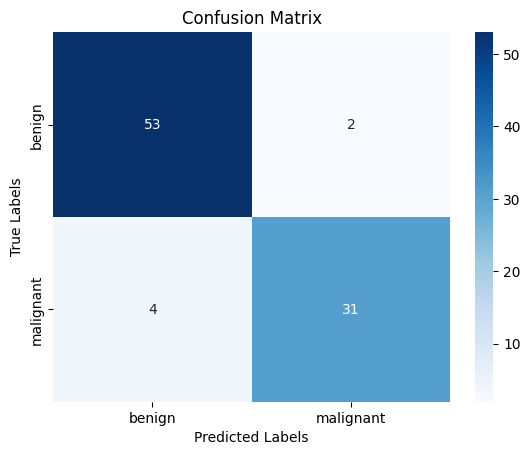

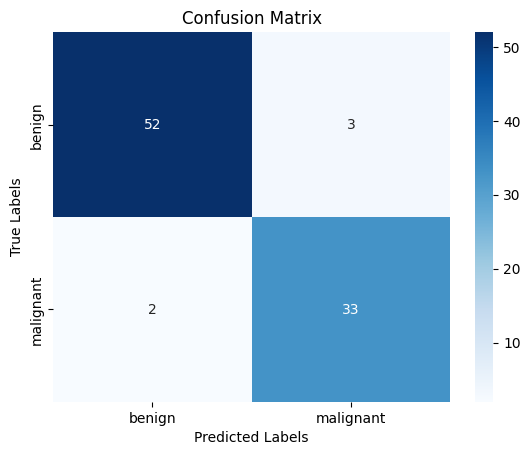

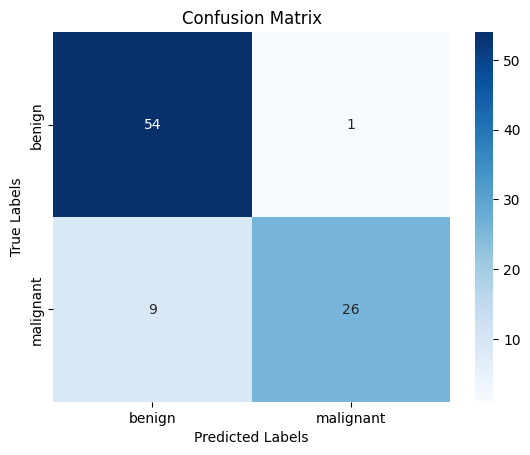

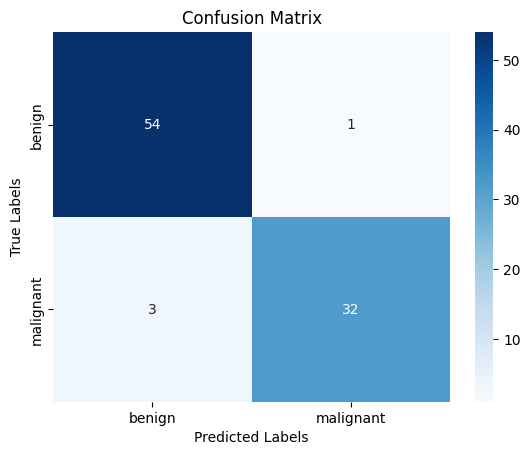

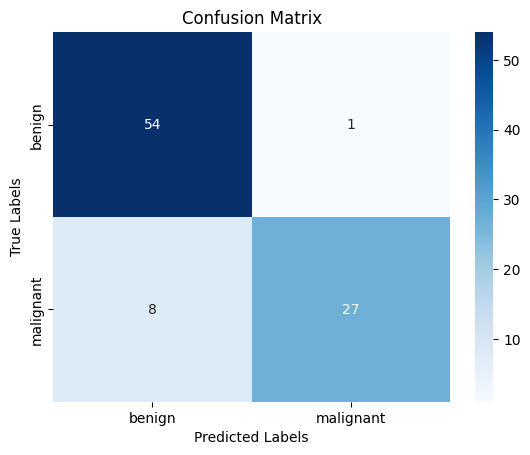

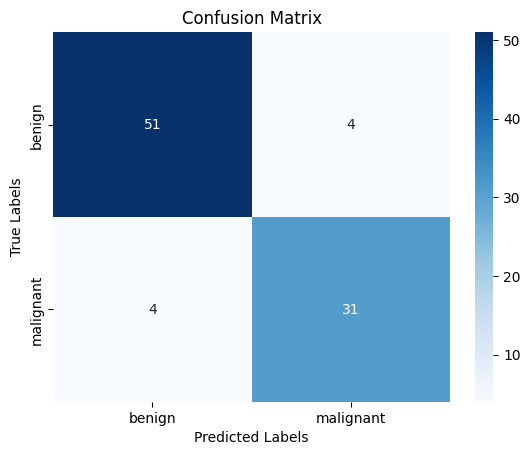

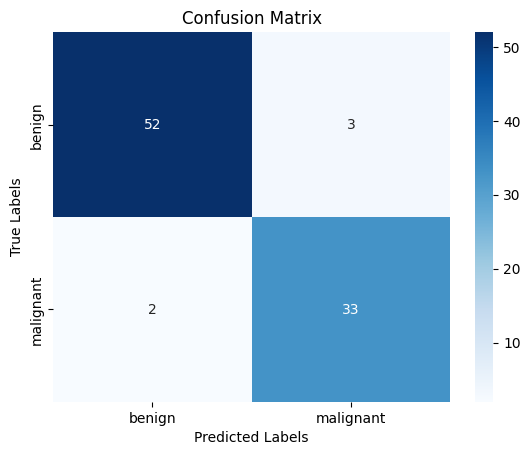

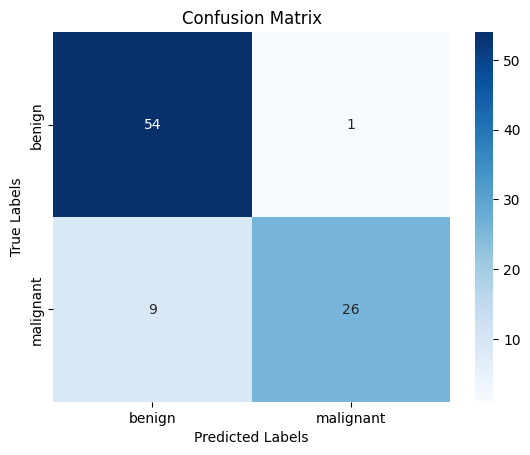

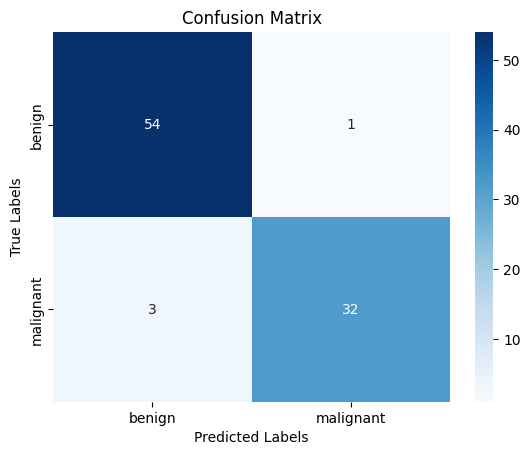

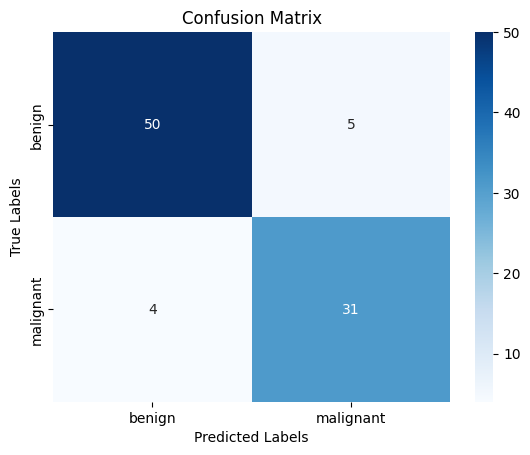

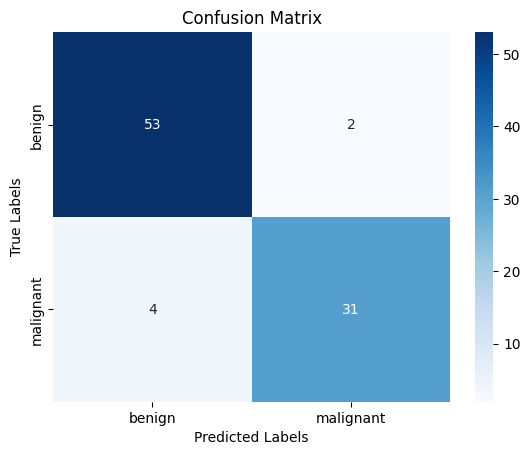

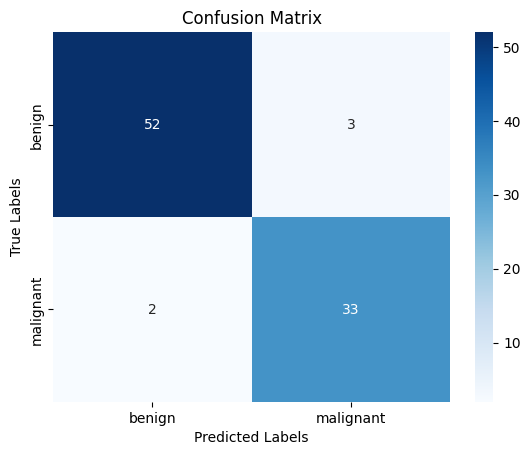

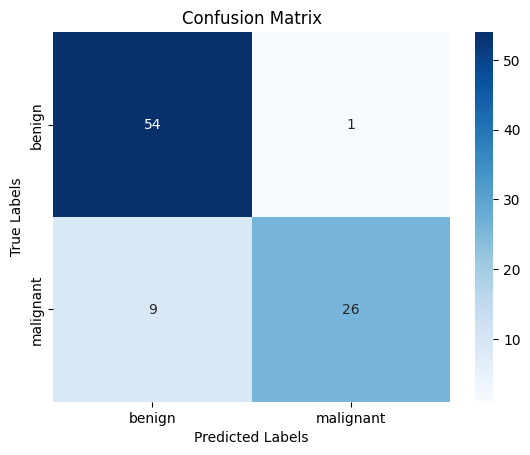

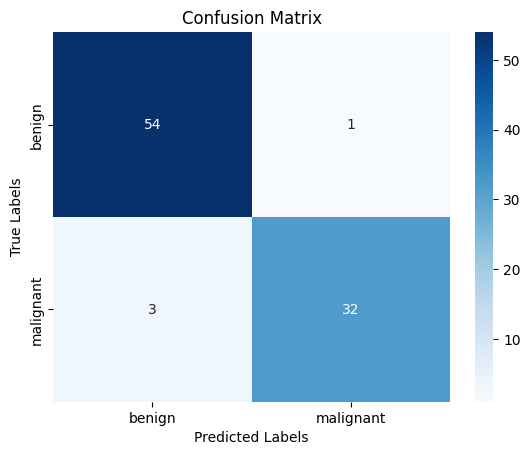

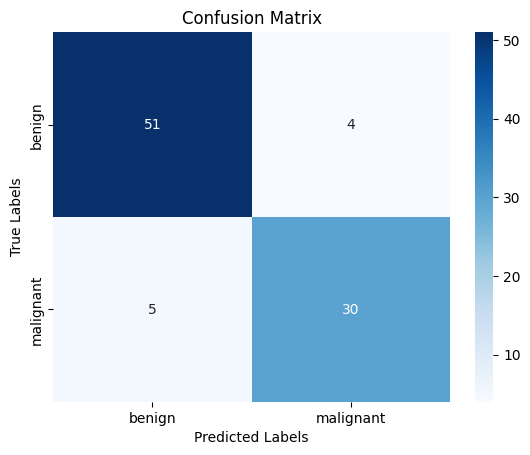

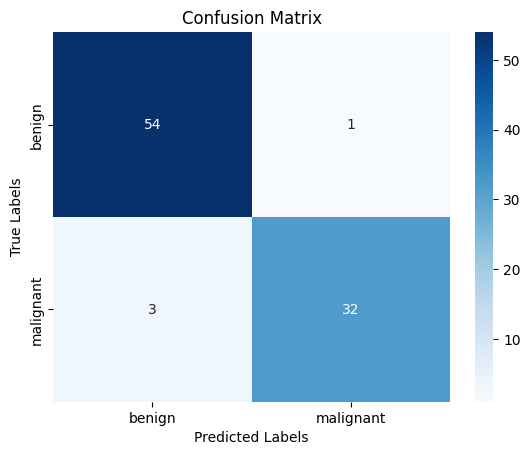

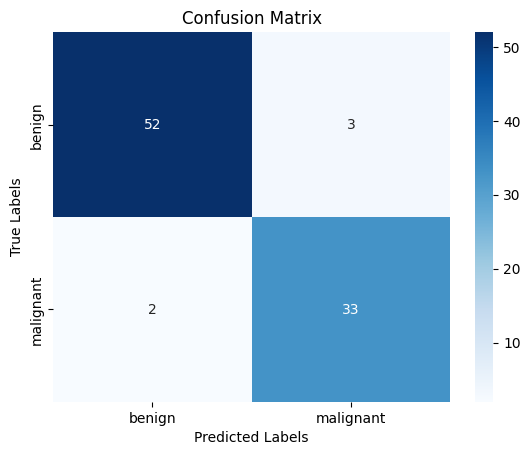

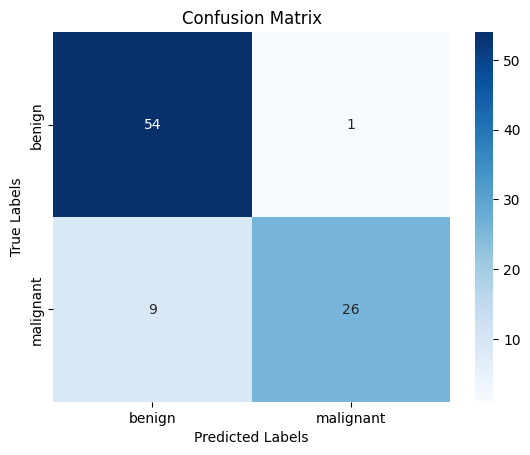

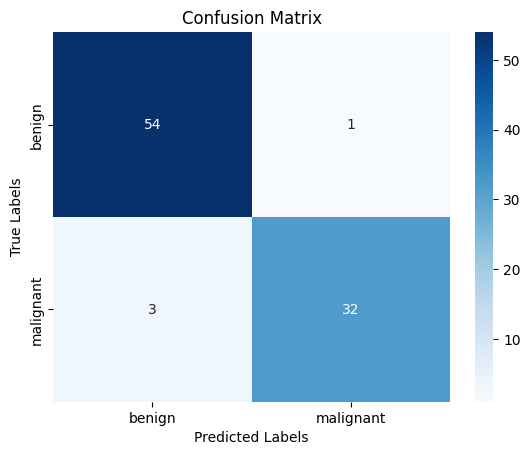

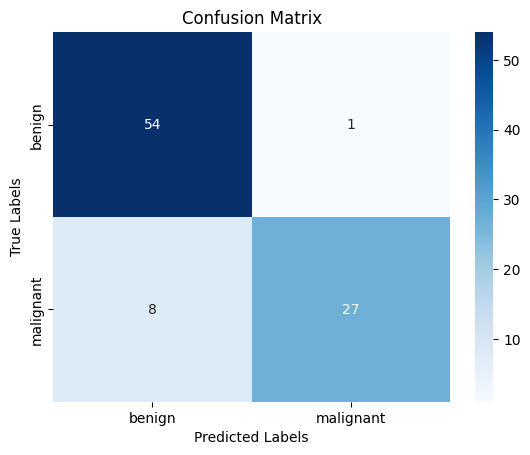

In [12]:
for i in range(4):
    for l in liste:
        print(l)
        ##########**A COMPLETER**########## 1. Récupération des prédicions
        y_pred = entrainement_prediction(l)[1]

        run_description = """
        Le jeu de données "Breast Cancer Wisconsin (Diagnostic) Data Set" est un ensemble de données largement utilisé dans le domaine de l'apprentissage automatique pour la classification binaire, en particulier pour la prédiction du diagnostic de cancer du sein (maligne vs bénigne). 
        Il a été créé par le Dr. William H. Wolberg à l'Université du Wisconsin-Madison.


        L'ensemble de données comprend des caractéristiques calculées à partir d'images numérisées de biopsie de tissus mammaires. 
        Ces caractéristiques décrivent les noyaux cellulaires présents dans les images et sont calculées à partir d'une image numérisée d'une ponction à l'aiguille fine (FNA) d'une masse mammaire. 
        Elles incluent des mesures telles que le rayon moyen des cellules, la texture, la périmétrie, l'aire, la douceur, la compacité, la concavité, les points concaves, la symétrie, et la dimension fractale.
        """
    
        tags = {
            'mlflow.note.content': run_description
        }

        ##########**A COMPLETER**########## 2. Collecte des metriques de log
        with mlflow.start_run(log_system_metrics=True, tags=tags) as run:
    
            time.sleep(15)
            
            # Chargement des métadonnées
            mlflow.log_param("Nombre de lignes", X.shape[0])
            mlflow.log_param("Nombre de caractéristiques", X.shape[1])
            
            ##########**A COMPLETER**########## 3. Chargement des Hyperparametres
            mlflow.log_params(hyperparametre(l)) #**A COMPLETER**

            ##########**A COMPLETER**########## 4. Definition des tags
            mlflow.set_tag("Dataset information", "Cancer")
            mlflow.set_tag("Model used", l)
        
            ##########**A COMPLETER**########## 5. Chargement des metriques
            mlflow.log_metric("accuracy", accuracy(y_test, y_pred))
            mlflow.log_metric("precision", precision(y_test, y_pred))
            mlflow.log_metric("recall", recall(y_test, y_pred))
            mlflow.log_metric("f1", f1(y_test, y_pred))

            ##########**A COMPLETER**########## 6. Chargement de la matrice de confusion en temps qu'artefact
            mlflow.log_artifact(conf_matrix(y_test, y_pred))
            
            ##########**A COMPLETER**########## 7. Chargement des donnees (Sauvegarde dans un fichie CSV, Enregistrement comme artefact)
            mlflow.log_artifact(file_path, "dataset")

            dataset_training = mlflow.data.from_pandas(X_train,
              source="file_path",
              name="Cancer"
            )
            mlflow.log_input(dataset_training, context="training")

            ##########**A COMPLETER**########## 8. Ajout du dataset de test dans l'interface des expériences
            dataset_test = mlflow.data.from_pandas(X_test,
              source="file_path",
              name="Cancer"
            )
            mlflow.log_input(dataset_test, context="test")
        
            # Signature
            signature = infer_signature(X_train, y_pred)
        
            model_info = mlflow.sklearn.log_model(
                sk_model=entrainement_prediction(l)[0], ##########**A COMPLETER**########## 9. Chargement du modèle
                artifact_path="Cancer_Model",
                signature=signature,
                input_example=X_train,
            )
        
            eval_data = pd.DataFrame(X_test)
            eval_data["tumor"] = y_test.tolist()
        
        print(mlflow.MlflowClient().get_run(run.info.run_id).data)